# Modeling and Simulation in Python

Chapter 10 Example: Spiderman

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [80]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib notebook

from modsim import *


I'll start by getting the units we'll need from Pint.

In [121]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

### Dropping people

We'll develop a model of a person bungee jumping from the top of the Empire State Building.  Let's assume that the bungee cord hangs from a crane that's far enough from the side of the building.

First I'll create a `Condition` object to contain the quantities we'll need.  They are the same as in Chapter 9, except:

1. I'll assume the person is 75 kg.

2. With a terminal velocity of 60 m/s.

3. The length of the bungee cord is 100 m.

4. The spring constant of the cord is 20 N / m when the cord is stretched, and 0 when it's compressed.

In [157]:
condition = Condition(height = 381 * m,
                      g = 9.8 * m/s**2,
                      mass = 75 * kg,
                      area = 1 * m**2,
                      rho = 1.2 * kg/m**3,
                      v_term = 60 * m / s,
                      duration = 15 * s,
                      length = 100 * m,
                      k = 20000 * N / m)

Now here's a version of `make_system` that takes a `Condition` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [158]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    A = Vector(0, height)
    
    r = length
    angle = (270 - 45) * degree
    theta = angle.to(radian)
    x, y = pol2cart(theta, r)
    L = Vector(x, y)
    P = A + L
    V = Vector(0*m/s, 0*m/s)
    
    init = State(x=P.x, y=P.y, vx=V.x, vy=V.y)
    C_d = 2 * mass * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 101)
    
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, length=length,
                  A=A, S=S, k=k, ts=ts)

Let's make a `System`

In [159]:
system = make_system(condition)
system

,value
init,x -70.71067811865477 meter y 310.28932...
g,9.8 meter / second ** 2
mass,75 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.3402777777777778 dimensionless
area,1 meter ** 2
length,100 meter
A,"[0 meter, 381 meter]"
S,"[-100 meter, 281 meter]"
k,20000.0 newton / meter


### 

Here's the slope function, including acceleration due to gravity and drag.

In [160]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    P = Vector(x, y)
    V = Vector(vx, vy)
    L = P - A
    
    f_spring = -k * (L.mag - length) * L.hat()
    a_spring = f_spring / mass
    
    f_drag = -rho * V.mag * V * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag + a_spring
    
    return vx, vy, a.x, a.y

As always, let's test the slope function with the initial conditions.

In [161]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(2.6796244628203095e-12, 'meter / second ** 2')>,
 <Quantity(-9.799999999997322, 'meter / second ** 2')>)

And then run the simulation.

In [162]:
run_odeint(system, slope_func)

### Visualizing the results

We can extract the x and y components as `Series` objects.

In [163]:
xs = system.results.x
ys = system.results.y

The simplest way to visualize the results is to plot x and y as functions of time.

<IPython.core.display.Javascript object>


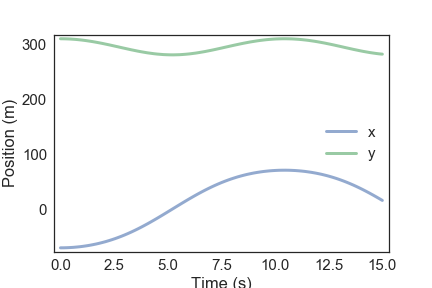

In [164]:
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

We can plot the velocities the same way.

In [165]:
vxs = system.results.vx
vys = system.results.vy

The x velocity slows down due to drag.  The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

<IPython.core.display.Javascript object>


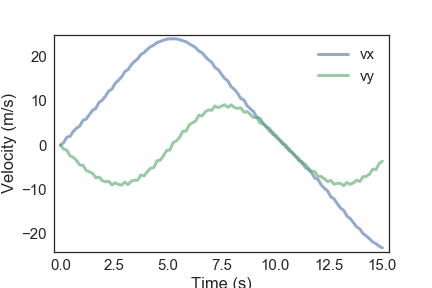

In [166]:
newfig()
plot(vxs, label='vx')
plot(vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

<IPython.core.display.Javascript object>


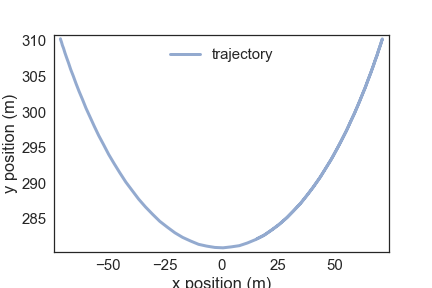

In [167]:
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

We can also animate the flight of the ball.  If there's an error in the simulation, we can sometimes spot it by looking at animations.

<IPython.core.display.Javascript object>


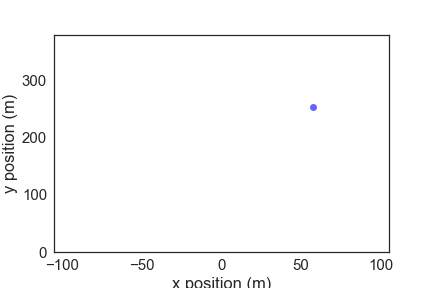

In [103]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[-105, 105],
         ylim=[0, 381],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

Here's a function that encapsulates that code and runs the animation in (approximately) real time.

In [78]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

<IPython.core.display.Javascript object>


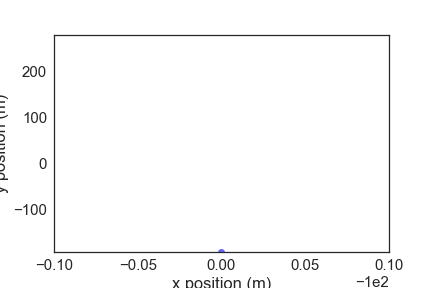

/home/downey/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-100.0, right=-100.0
  'left=%s, right=%s') % (left, right))


<IPython.core.display.Javascript object>


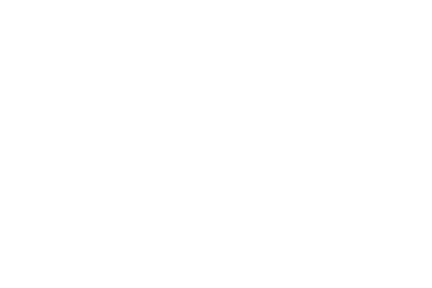

In [79]:
animate2d(system.results.x, system.results.y)